# Biot-Savart in Julia

### Units
The full Biot-Savart integral is
$$
\mathbf{B}\left( \mathbf{r} \right) = \frac{\mu_0}{4\pi} \int_C \frac{I\, d\mathbf{l}\, \times \mathbf{r'}}{ \left| \mathbf{r'} \right|^3 },
$$
where $\mathbf{r'}$ is the vector connecting the point of observation, $\mathbf{r}$, to the current-carrying line element $d\mathbf{l}$. The units of $\mu_0$ are $\mathrm{H}/\mathrm{m} \equiv \mathrm{T}\cdot\mathrm{m}/\mathrm{A}$, so as expected the units of the entire integral are in $\mathrm{T}$. We prefer to express magnetic fields in $\mathrm{G} \equiv 10^{-4} \mathrm{T}$. If we specify our paths in millimeters, this means that the prefactor $\mu_0/4\pi \approx 10^{-7} \mathrm{H/m}$ drops out, and we can get away with less bookkeeping.

This has one consequence for the gradients and curvatures that we calculate. The length units of these will now also be assumed to be in millimeters, so if we prefer to express a gradient in $\mathrm{G/cm}$ we'll have to multiply by a factor of 10, and if we want to express a curvature in $\mathrm{G/cm}^2$ that warrants a factor 100.

In [3]:
using ForwardDiff
using Plots, Interact
using BenchmarkTools
Plots.pyplot()
Plots.plotly()

# Load our own module defining coil paths
if !(@isdefined Coils)
    include("./coils.jl")
    using .Coils
end

In [4]:
function pathVec(pointArray::Array{Float64,2})
    #assume pointArray is an 2d array 3 X N
    #assume the path vector associated with the end of the path is a zero vector.
    return hcat(pointArray[:,2:end]-pointArray[:,1:end-1],[0.0, 0.0, 0.0])
end


function normCubed(x)
    #calculates |x|^3
    return sqrt.(sum(x.^2, dims = 1)).^3
end

function crossArray(x,y)
    #assume input arrays are 2d array 3 X N
    #returns 3XN array
    #return hcat(x[2,:].*y[3,:]-y[2,:].*x[3,:], x[3,:].*y[1,:]-y[3,:].*x[1,:],x[1,:].*y[2,:] - y[1,:].*x[2,:])'
    xX = @view x[1,:]
    xY = @view x[2,:]
    xZ = @view x[3,:]
    yX = @view y[1,:]
    yY = @view y[2,:]
    yZ = @view y[3,:]
    return hcat(xY.*yZ-yY.*xZ, xZ.*yX-yZ.*xX,xX.*yY - yX.*xY)'
end


function biasField(probePoint,pathElement,dlvec)
    #computes dl⃗ × r⃗./normCubed(rvec)³
    rvec = pathElement.-probePoint
    return sum(crossArray(dlvec,rvec)./normCubed(rvec), dims = 2)
end

function fieldNorm(x,pathElement,dlvec)
   return sqrt(sum(biasField(x,pathElement,dlvec).^2))
end

function fieldZComponent(x, pathElement, dlvec)
    return biasField(x, pathElement, dlvec)[3]
end

function fieldNormplusBias(x,pathElement,dlvec)
   return sqrt(sum( ( biasField(x,pathElement,dlvec) + [0,0,0]  ).^2))
end

fieldNormplusBias (generic function with 1 method)

In [5]:
normGrad(x) = ForwardDiff.gradient(x->(fieldNorm(x,path,dl)),x)
normCurve(x) = ForwardDiff.hessian(x->(fieldNormplusBias(x,path,dl)),x)

normCurve (generic function with 1 method)

In [6]:
#warmup - let JIT compiler compile the functions
angRes = 0.02;
t = 0.0:angRes:(2*pi*1.0);
path = permutedims(1.0.*hcat(cos.(t),sin.(t),zero(t)))
probeLocation = [0.0, 0.0, 0.0];
dl = pathVec(path);

fieldNorm(probeLocation,path,dl)
normGrad(probeLocation)
normCurve(probeLocation)

3×3 Array{Float64,2}:
 9.40504      0.000427842    0.0   
 0.000427842  9.4337         0.0   
 0.0          0.0          -18.8387

In [7]:
#compare the field generated by a single loop and the analytical results

wow = Array{Float64,1}();
for i=-2:0.001:2
    push!(wow,fieldNorm([0.0,0.0,i],path,dl))
end

z = collect(-2:0.001:2);
realNormZ = 2*pi*1*(1).*(1^2 .+ z.^2).^(-1.5)
plot(z,wow,linewidth=2,title="JuliaDiff vs Analytical Field Norm")
plot!(z,realNormZ)

<!DOCTYPE html>
 
 
 Plots.jl

In [8]:
wow = Array{Float64,1}();
for i=0.001:0.01:2
    push!(wow,normGrad([0.0,0.0,i])[3])
end

z = collect(0.001:0.01:2);
realGradZ = 2*pi*1*(1)*(-3*z).*(1^2 .+ z.^2).^(-2.5)
plot(z,wow,linewidth=2,title="JuliaDiff vs Analytical Grad")
plot!(z,realGradZ)

<!DOCTYPE html>
 
 
 Plots.jl

In [9]:
plt = plot(linewidth=2,title = "Numerical difference between JuliaDiff and Analytical Grad")
for angRes in [0.01,0.003,0.001,0.0001]
    t = 0.0:angRes:(2*pi*1.0);
    path = permutedims(1.0.*hcat(cos.(t),sin.(t),zero(t)))
    dl = pathVec(path);

    wow = Array{Float64,1}();
    for i=0.001:0.01:2
        push!(wow,normGrad([0.0,0.0,i])[3])
    end
    plot!(z,log10.(abs.((wow-realGradZ)./realGradZ)),label = "angRes = $angRes")
end

In [10]:
plt

<!DOCTYPE html>
 
 
 Plots.jl

In [11]:
bzDD = @. 2*pi*(1.0)*(-3.0)*(1.0^2-4.0*z^2)/sqrt((1.0^2 + z^2)^7)
wowww = Array{Float64,1}()
    for i in z
        push!(wowww,normCurve([0.0,0.0,i])[3,3])
    end
plot(z,wowww,linewidth=2,title="ForwardDiff.hessian vs Analytical Curvature")
plot!(z,bzDD)

<!DOCTYPE html>
 
 
 Plots.jl

### Define path and dl for the coil geometry being tested

* Assume we use 3.175 mm (1/16 '') outer side length hollow core wire.   
* In his computer simulation of the Zeeman slower, Erik Streed assumes a physical width of 3.5 mm for the wire to account for the epoxy.
* The physical dimension of wire in calculation is 3.5 mm   

### Generate path of counter-wound coil pair

Starting from the positive lead, assume you wind spiraling in, clockwise, with N turns.   
After finishing N clockwise turns, you move in N x (wire thickness) radially.   
Then you change layer. Assume you go down.   
In the new layer, the helicity of the winding stays the same with respect to the z-axis, (clockwise) but you spiral OUT.
But the top layer does not completely overlap the bottom layer. There is some displacement of a wire thickness.

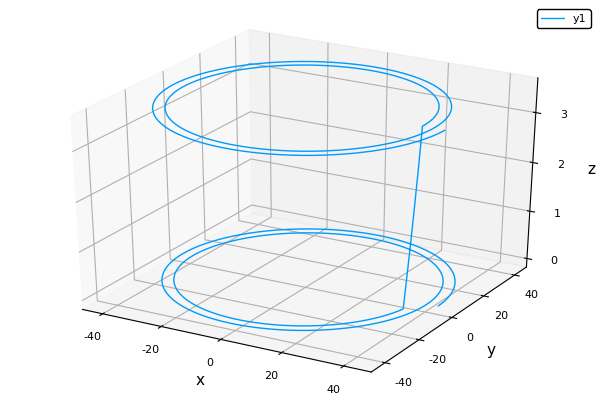

In [15]:
#First try: wind coils starting from the outer diameter of the objective to the inner wall of flange
#The space between objective and flange can only fit in 3 coils, 6 doublelayer coil stack.
#Let's try to describe the geometry with (3 spiral-,3 counterspiral-turns) with a 3D plot,
# note: n turns means total of n+1 thickness along the radial direction

sign=-1;
samplecoil = coilStack(0.0,2,71/2,sign) # the diameter for the objective = 71 mm

# Switch plotting backends to get interactive view
#plotly()
pyplot()
plt = path3d(samplecoil[:,1], samplecoil[:,2], samplecoil[:,3], xlab = "x", ylab="y", zlab="z")

### Generate path for regular coil winding
Different from double layer spiral coils, the normal coil winding models coils formed by multilayer helices. 
The pictch direction (+/-) alternates between neighboring layers.

We add an extra winding at the end of each helix that is flat, i.e. its height doesn't change. The radius grows outward with one wire thickness, and then it starts spiralling down again.

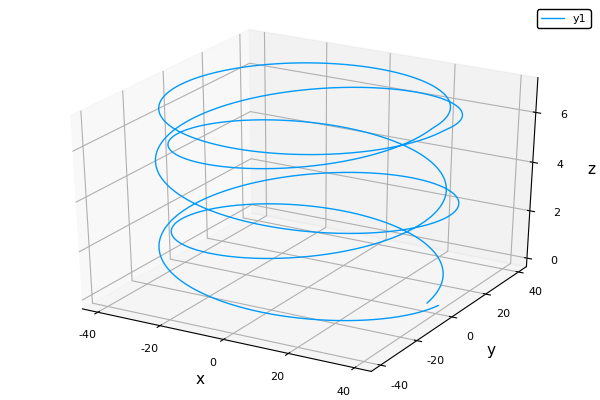

In [16]:
sign=1;
samplecoil = normalCoil(0.0,2,2,71/2,sign) # the diameter for the objective = 71 mm

# Switch plotting backends to get interactive view
#plotly()
pyplot()
plt = path3d(samplecoil[:,1], samplecoil[:,2], samplecoil[:,3], xlab = "x", ylab="y", zlab="z")

### Field comparison between double layer (spiral) vs normal winding (helix)  

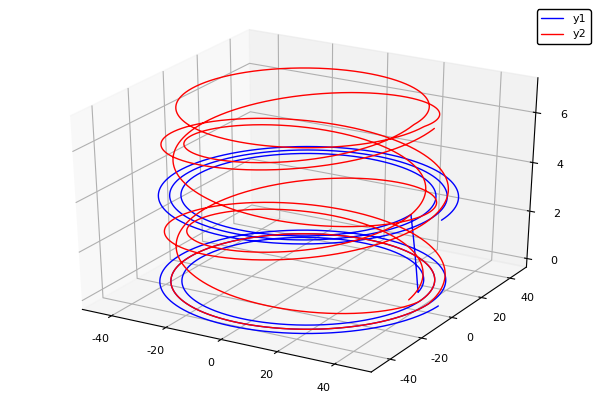

In [17]:
path1 = Array{Float64,2}(undef, 3,0)
dl1 = Array{Float64,2}(undef, 3,0)
path2 = Array{Float64,2}(undef, 3,0)
dl2 = Array{Float64,2}(undef, 3,0)
pyplot()

p1=permutedims(coilStack(0.0,3,71/2,1));
dp1 = pathVec(p1)
path1 = hcat(path1,p1)
dl1 = hcat(dl1,dp1)
path3d(p1[1,:],p1[2,:],p1[3,:],color = "blue")

p2=permutedims(normalCoil(0.0,2,3,71/2,1));
dp2 = pathVec(p2)
path2 = hcat(path2,p2)
dl2 = hcat(dl2,dp2)

path3d!(p2[1,:],p2[2,:],p2[3,:],color = "red")


In [18]:
bnorm1 = Array{Float64,1}();
bgrad1 = Array{Float64,1}();
bcx1 = Array{Float64,1}();
bcy1 = Array{Float64,1}();
bcz1 = Array{Float64,1}();
bnorm2 = Array{Float64,1}();
bgrad2 = Array{Float64,1}();
bcx2 = Array{Float64,1}();
bcy2 = Array{Float64,1}();
bcz2 = Array{Float64,1}();

for i=-10:0.2:10
    push!(bnorm1,fieldZComponent([0.0,0.0,i],path1,dl1))
    push!(bgrad1,normGrad([0.0,0.0,i])[3])
    nc = normCurve([0.0,0.0,i])
    push!(bcz1,nc[3,3])
    push!(bcy1,nc[2,2])
    push!(bcx1,nc[1,1])
end

for i=-10:0.2:10
    push!(bnorm2,fieldZComponent([0.0,0.0,i],path2,dl2))
    push!(bgrad2,normGrad([0.0,0.0,i])[3])
    nc = normCurve([0.0,0.0,i])
    push!(bcz2,nc[3,3])
    push!(bcy2,nc[2,2])
    push!(bcx2,nc[1,1])
end

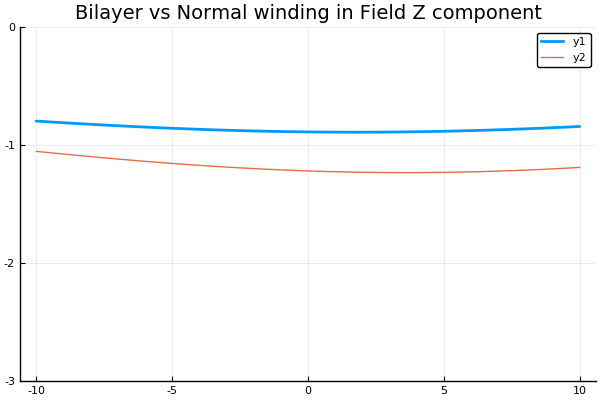

In [14]:
z = collect(-10:0.2:10)
plot(z,bnorm1,linewidth=2,ylim=(-3,0),title="Bilayer vs Normal winding in Field Z component")
plot!(z,bnorm2)

[15.75, 12.25, -16.24, -19.74]

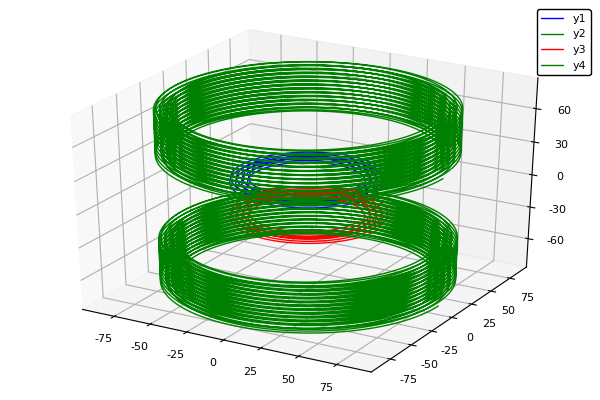

In [15]:
#realistic coil stack
path = Array{Float64,2}(undef, 3,0)
dl = Array{Float64,2}(undef, 3,0)
plt2 = path3d()
#plt3 = path3d()
nstacks = 1;
height = Array{Float64,1}();
amp=1;

#double layer
sign=1
innerRadius=29.55+3.5/2
for i=nstacks:-1:1
    zpos=6.5+4+3.5/2+3.5*2*(i-1) # 6.5mm is the distance from atom to the window. 4mm is from window to the bottom of first coil layer
    
    #zpos=35.5+3.5/2
    if i==1
        p = permutedims(coilStack(0.0+2*pi/nstacks * (i-1),4,innerRadius,sign,3.5,0.002,zpos)) ##### 29.55+3.5/2 measured from solidworks
    else
        p = permutedims(coilStack(0.0+2*pi/nstacks * (i-1),2,innerRadius,sign,3.5,0.002,zpos)) 
    end
    dp = pathVec(p)
    path = hcat(path,p)
    dl = hcat(dl,dp)
    path3d!(p[1,:],p[2,:],p[3,:],color = "blue")
    #path3d!(dp[1,:],dp[2,:],dp[3,:])
    height=push!(height,zpos+3.5,zpos)
   
end

#normal coils
pitch=12;
layers=4;
bucket_radius=75.9
zpos=35.306+3.5./2 ###35.4 obtained from solidworks drawing

p=permutedims(normalCoil(0.0,pitch,layers,bucket_radius,sign,3.5,0.002,zpos));
dp = pathVec(p)
path = hcat(path,p)
dl = hcat(dl,dp)
path3d!(p[1,:],p[2,:],p[3,:],color = "green")

#add bottom gradient coils, flip winding clockness, sign=1-->-1, and the current direction is flipped automatically.
sign=1
for i=1:nstacks
    zpos=-10.49-4-3.5/2 - 3.5*(2*i-1)        ##############base thickness of the UKEAE viewport, is it 4????#################
    #zpos=-35.5-3.5-3.5/2
    if i==1
        p = permutedims(coilStack(0.0+2*pi/nstacks * (i-1),4,innerRadius,sign,3.5,0.002, zpos))  
    else
        p = permutedims(coilStack(0.0+2*pi/nstacks * (i-1),2,innerRadius,sign,3.5,0.002, zpos)) 
    end
    
    dp = pathVec(p)
    path = hcat(path,p)
    dl = hcat(dl,dp)
    path3d!(p[1,:],p[2,:],p[3,:],color = "red")
    #path3d!(dp[1,:],dp[2,:],dp[3,:])
    height=push!(height,zpos+3.5,zpos)
end
print(height)

#normal coils
zpos=-35.306-3.5/2-pitch*3.5
p=permutedims(normalCoil(0.0,pitch,layers,bucket_radius,sign,3.5,0.002,zpos));
dp = pathVec(p)
path = hcat(path,p)
dl = amp*hcat(dl,dp)
path3d!(p[1,:],p[2,:],p[3,:],color = "green")

# Switch plotting backends to get interactive view
pyplot()
#plotly()

plt2

In [16]:
zpos=35.306+3.5./2
upNormalHeight=Array{Float64,1}();
for i=1:pitch
    upNormalHeight=push!(upNormalHeight,zpos+(i-1).*3.5) ##### The extra +3.5/2 is to take the middle height of one single helix
end
upNormalHeight

zpos=-35.306-3.5/2-pitch*3.5
bottomNormalHeight=Array{Float64,1}();
for i=1:pitch
    bottomNormalHeight=push!(bottomNormalHeight,zpos+i.*3.5) ##### The extra -3.5/2 is to take the middle height of one single helix
end
bottomNormalHeight

normalHeight=vcat(upNormalHeight,bottomNormalHeight)
normalHeight

24-element Array{Float64,1}:
  37.056
  40.556
  44.056
  47.556
  51.056
  54.556
  58.056
  61.556
  65.056
  68.556
  72.056
  75.556
 -75.556
 -72.056
 -68.556
 -65.056
 -61.556
 -58.056
 -54.556
 -51.056
 -47.556
 -44.056
 -40.556
 -37.056

In [17]:
bnorm = Array{Float64,1}();
bgrad = Array{Float64,1}();
bcx = Array{Float64,1}();
bcy = Array{Float64,1}();
bcz = Array{Float64,1}();
for i=-4:0.1:4
    push!(bnorm,fieldZComponent([0.0,0.0,i],path,dl))
    push!(bgrad,normGrad([0.0,0.0,i])[3])
    nc = normCurve([0.0,0.0,i])
    push!(bcz,nc[3,3])
    push!(bcy,nc[2,2])
    push!(bcx,nc[1,1])
end

In [18]:
# Switch plotting backends to get static view
#pyplot()
plotly()

plot(-4:0.1:4,bgrad*10,title = "magnetic field gradient (G/(cm*Amp)")

<!DOCTYPE html>
 
 
 Plots.jl

In [19]:
bgrad[41]*10

-0.021348744979773203

In [20]:
plotly()
plot(-4:0.1:4,bcx*100,title = "magnetic field curvature (G/(cm^2 * Amp))")
plot!(-4:0.1:4,bcy*100)
plot!(-4:0.1:4,bcz*100)

<!DOCTYPE html>
 
 
 Plots.jl

In [21]:
bcx[41]*100

0.01682863472925805

In [22]:
bcy[41]*100

0.0170250230172404

In [23]:
bcz[41]*100

-0.03381680829312642

In [24]:
#find the analytical solution of the coil design by treating each layer by a single loop
anaNormZ = Array{Float64,1}();

z = collect(-4:0.1:4)
anaNormZ=zeros(length(z))



###contribution from bilayer############
turns=4;

for j=1:turns
    r=29.55+3.5+(j-1).*3.5

    for i=1:Int(length(height)/2)
        anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-height[i]).^2).^(-1.5)
    end

    for i=Int(length(height)/2)+1:Int(length(height))
        anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-height[i]).^2).^(-1.5)
    end
end

###contribution from normal winding coils############

print(layers)

for j=1:layers
    r=bucket_radius+(j-1).*3.5
    for i=1:Int(length(normalHeight)/2)
        anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[i]).^2).^(-1.5)
    end

    for i=Int(length(normalHeight)/2)+1:Int(length(normalHeight))
        anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[i]).^2).^(-1.5)
    end
end

###contribution from transition part in normal winding coils############
r=bucket_radius+3.5/2
anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[pitch].-3.5).^2).^(-1.5)
anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[pitch*2].-3.5).^2).^(-1.5)


plot(z,bnorm,linewidth=2,title="Realistic vs Analytical Field Norm")
plot!(z,-anaNormZ)




4

<!DOCTYPE html>
 
 
 Plots.jl

In [25]:
bnorm[41]

-6.314030668983398

In [26]:
@btime normCurve([0.0,0.0,0.0])*100

  958.555 ms (64 allocations: 1.02 GiB)


3×3 Array{Float64,2}:
 0.0168286    0.000228363   7.2639e-5 
 0.000228363  0.017025      0.00167636
 7.2639e-5    0.00167636   -0.0338168 

In [27]:
@btime normGrad([0.0,0.0,0.0])*10

  262.813 ms (57 allocations: 260.20 MiB)


3-element Array{Float64,1}:
 -3.880643314785868e-5 
  0.0004389596308553169
 -0.021348744979773203 

In [28]:
@btime fieldNorm([0.0,0.0,0.0],path,dl)

  40.072 ms (53 allocations: 65.05 MiB)


6.3140322101369835